In [5]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import qgrid
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import seaborn as sns

In [2]:
df = pd.read_parquet('./ancillary_stats_from_june_2020.parquet')
df_ibe = pd.read_parquet('./agg_stat_product_ibe3_from_june_2020.parquet')


In [10]:
segments_sold_per_day = df_ibe[df_ibe.product_type=='breakdown'].groupby('product_creation_date')['sum_seg_count'].agg('sum')

In [11]:
segments_sold_per_day.plot()

In [12]:
df=df[df.product_creation_date<df.product_creation_date.max()]

In [13]:
for col in df.columns:
    print(col, sum(df[col].isna()))

product_type 0
product_creation_date 0
departure 16458
arrival 16458
pos 148283
sum_price 0
sum_quantity 0
count_rows 0


In [14]:
df['departure'] = df['departure'].fillna('XXX')
df['arrival'] = df['arrival'].fillna('XXX')
df['pos']=df['pos'].fillna('Undefined')

/tmp/ipykernel_33855/4277044254.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33855/4277044254.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33855/4277044254.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
df['ond']=df.departure+'-'+df.arrival

/tmp/ipykernel_33855/1265636786.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
df = df.groupby(['product_type','product_creation_date','ond'])[['sum_price','sum_quantity','count_rows']].agg('sum').reset_index()

In [17]:
prod_counts = df.product_type.value_counts()
prod_counts

seat                155835
sms                 126488
bag                 122123
meal                 75817
pet                  47434
upgrade              36545
auto_checkin         15486
lounge               12615
foodbox               4441
flight_change          864
prepay                 506
aeroexpress            506
insurance              506
hotel                  506
gift_certificate       496
car                    492
transfer               429
extra_seat             237
free_refund             95
fast_track              84
Name: product_type, dtype: int64

In [18]:
tracked_products=list(prod_counts[prod_counts>10000].index)
print('Tracked products:', tracked_products)
df=df[df.product_type.isin(tracked_products)]


Tracked products: ['seat', 'sms', 'bag', 'meal', 'pet', 'upgrade', 'auto_checkin', 'lounge']


In [19]:
dir_counts = df.groupby(['ond'])['sum_quantity'].agg('sum').sort_values()
tracked_dirs = set(dir_counts[dir_counts>10000].index)

In [20]:
untracked_dir_idx = ~df.ond.isin(tracked_dirs)

In [21]:
df.loc[untracked_dir_idx,'ond'] = 'XXX-XXX'

In [22]:
d1 = df.groupby(['product_type','product_creation_date'])['sum_quantity'].agg('sum').reset_index()

In [23]:
import plotly.express as px
px.line(d1, x='product_creation_date', y='sum_quantity', color='product_type', log_y=True)

In [24]:
sales = pd.DataFrame({
  'holiday': 'sale',
  'ds': pd.to_datetime(['2021-09-14', '2020-06-23','2020-09-15', '2020-11-10', '2020-12-15','2021-01-19', '2021-03-23']),
  'lower_window': 0,
  'upper_window': 4,
})

In [62]:
tbl = d1.set_index(['product_creation_date','product_type']).unstack()
cols = [c[1] for c in tbl.columns]
tbl.columns = cols


tbl = pd.merge(tbl, segments_sold_per_day,
        left_index=True, right_index=True)

# for col in cols:
#     tbl[col]=tbl[col]/tbl['sum_seg_count']
# tbl=tbl.drop(columns=['sum_seg_count'])    

tbl['total'] = tbl.loc[:, cols].sum(axis=1)

tbl

,auto_checkin,bag,lounge,meal,pet,seat,sms,upgrade,sum_seg_count,total
product_creation_date,,,,,,,,,,
2020-06-01,NaN,478.0,9.0,169.0,102.0,5064.0,845.0,39.0,26921.0,6706.0
2020-06-02,NaN,455.0,13.0,207.0,90.0,5243.0,949.0,55.0,27964.0,7012.0
2020-06-03,NaN,490.0,13.0,249.0,132.0,5289.0,965.0,50.0,27973.0,7188.0
2020-06-04,NaN,414.0,18.0,212.0,82.0,5336.0,830.0,68.0,28049.0,6960.0
2020-06-05,NaN,422.0,9.0,241.0,96.0,5303.0,896.0,55.0,28625.0,7022.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-15,266.0,1922.0,60.0,1150.0,199.0,16368.0,2734.0,338.0,71407.0,23037.0
2021-10-16,203.0,1624.0,39.0,800.0,185.0,13366.0,2185.0,339.0,47917.0,18741.0
2021-10-17,166.0,1712.0,60.0,926.0,156.0,14264.0,2117.0,297.0,44192.0,19698.0


In [63]:
hierarchy = {
    'total': cols
}

In [64]:
import hts
tree = hts.hierarchy.HierarchyTree.from_nodes(hierarchy, tbl)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)

In [65]:
reg = hts.HTSRegressor(
    model='prophet', 
    revision_method="NONE", # "OLS", "WLSS", "WLSV", "FP", "PHA", "AHP", "BU", "NONE"
    weekly_seasonality = True,
    holidays=sales,
    #daily_seasonality = True,
#     yearly_seasonality = True,
#     n_changepoints = 15,
    interval_width=0.95,
#     mcmc_samples = 300,
    n_jobs=0
)
reg = reg.fit(df=tbl, nodes=hierarchy, show_warnings=False)
# preds.append(reg.predict(steps_ahead=31, show_warnings=False))

Fitting models:   0%|                                                                                                                                                                                       | 0/9 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  11%|███████████████████▍                                                                                                                                                           | 1/9 [00:00<00:01,  5.40it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  22%|██████████████████████████████████████▉                                                                            

In [66]:
pred = reg.predict(steps_ahead=1, show_warnings=False)

Fitting models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.10s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fc196c87940>


In [67]:
t = tbl.stack().rename('orig')

p = pred.stack().rename('pred')

p.index = p.index.set_names(['date','category'])
t.index = t.index.set_names(['date','category'])

p.reset_index()

comp = pd.merge(
    p,t,
    left_index=True,
    right_index=True,
    how='outer'
)

comp = comp.stack().reset_index().rename(columns={'level_2':'kind', 0:'value'})

comp

import plotly.express as px
px.line(comp[comp.category=='seat'], x='date', y='value', color='kind', log_y=True)

In [69]:
tbl

,auto_checkin,bag,lounge,meal,pet,seat,sms,upgrade,sum_seg_count,total
product_creation_date,,,,,,,,,,
2020-06-01,NaN,478.0,9.0,169.0,102.0,5064.0,845.0,39.0,26921.0,6706.0
2020-06-02,NaN,455.0,13.0,207.0,90.0,5243.0,949.0,55.0,27964.0,7012.0
2020-06-03,NaN,490.0,13.0,249.0,132.0,5289.0,965.0,50.0,27973.0,7188.0
2020-06-04,NaN,414.0,18.0,212.0,82.0,5336.0,830.0,68.0,28049.0,6960.0
2020-06-05,NaN,422.0,9.0,241.0,96.0,5303.0,896.0,55.0,28625.0,7022.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-15,266.0,1922.0,60.0,1150.0,199.0,16368.0,2734.0,338.0,71407.0,23037.0
2021-10-16,203.0,1624.0,39.0,800.0,185.0,13366.0,2185.0,339.0,47917.0,18741.0
2021-10-17,166.0,1712.0,60.0,926.0,156.0,14264.0,2117.0,297.0,44192.0,19698.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.15964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       1247.13   0.000850997       103.446   5.016e-06       0.001      145  LS failed, Hessian reset 
      94       1247.37   0.000188344       51.9479   4.368e-06       0.001      200  LS failed, Hessian reset 
      99       1247.38   2.03491e-05       42.2455       0.314     0.00314      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       1247.38   2.34766e-07       30.1414       0.272           1      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


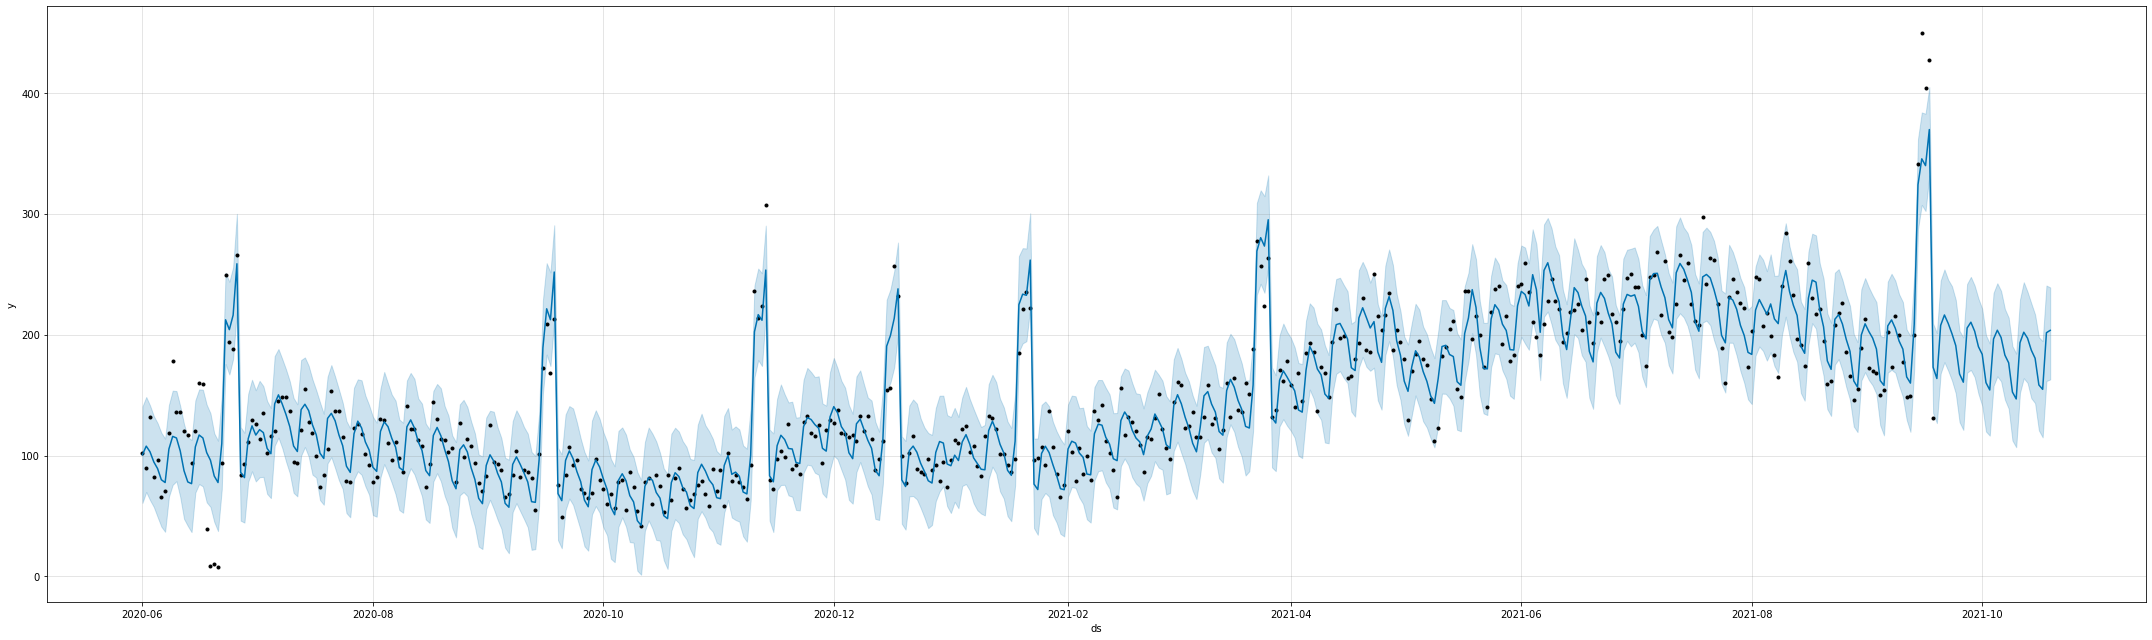

In [80]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
m = Prophet(
    weekly_seasonality = True,
    holidays=sales,
#     daily_seasonality = True,
    yearly_seasonality = True,
    n_changepoints = 3,
    interval_width=0.95,
#     mcmc_samples = 300,
)
target ='pet'
m.add_regressor('sum_seg_count')
data =tbl[[target,'sum_seg_count']].reset_index().rename(columns={'product_creation_date':'ds',target:'y'}) 

past = data[:-31]
future=data.drop(columns=['y'])

m.fit(past)

forecast = m.predict(future)
plt.figure(figsize=(30,9))
ax=plt.gca()
fig = m.plot(forecast,ax=ax)

In [78]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-01,80.882156,57.844659,141.220267,71.658534,91.217959,20.114644,6.031115,33.591832,-26.504209,...,5.977240,1.096930,10.548102,40.641613,31.967990,49.053257,0.0,0.0,0.0,100.996800
1,2020-06-02,81.115604,65.351112,147.267676,71.921123,91.411190,27.006245,13.310035,40.707602,-25.551584,...,11.819446,6.981953,16.308464,40.738383,32.088184,49.051736,0.0,0.0,0.0,108.121849
2,2020-06-03,81.349051,60.439741,145.969359,72.183711,91.604422,22.291030,7.987705,35.550758,-25.543364,...,7.286461,2.239069,12.231151,40.547933,31.811414,48.523136,0.0,0.0,0.0,103.640081
3,2020-06-04,81.582498,54.664946,134.937365,72.446300,91.797653,13.248168,0.510036,25.883003,-25.473949,...,-1.355406,-5.878395,3.310756,40.077524,31.124713,47.711587,0.0,0.0,0.0,94.830667
4,2020-06-05,81.815945,47.959122,129.907245,72.708888,91.990884,7.613300,-5.617016,20.869792,-24.947859,...,-6.780196,-11.352595,-2.065223,39.341355,30.471752,47.088771,0.0,0.0,0.0,89.429245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2021-10-15,204.261931,142.100861,228.252092,192.941426,215.827152,-22.135331,-34.562622,-10.806515,14.127120,...,-6.780196,-11.352595,-2.065223,-29.482255,-40.159011,-19.274676,0.0,0.0,0.0,182.126600
502,2021-10-16,204.516126,119.801711,201.466066,193.102764,216.202674,-44.486096,-56.461379,-32.676841,-7.327493,...,-7.992047,-13.257341,-2.711213,-29.166557,-39.738734,-18.631535,0.0,0.0,0.0,160.030029
503,2021-10-17,204.770320,116.056318,196.765361,193.264102,216.577212,-48.401152,-60.315976,-36.161796,-10.729725,...,-8.955498,-14.319844,-3.255456,-28.715930,-39.488559,-18.105619,0.0,0.0,0.0,156.369167
504,2021-10-18,205.024514,160.583048,244.201012,193.425440,216.950123,-1.731976,-14.342340,10.141577,20.438374,...,5.977240,1.096930,10.548102,-28.147590,-39.097304,-17.245934,0.0,0.0,0.0,203.292538


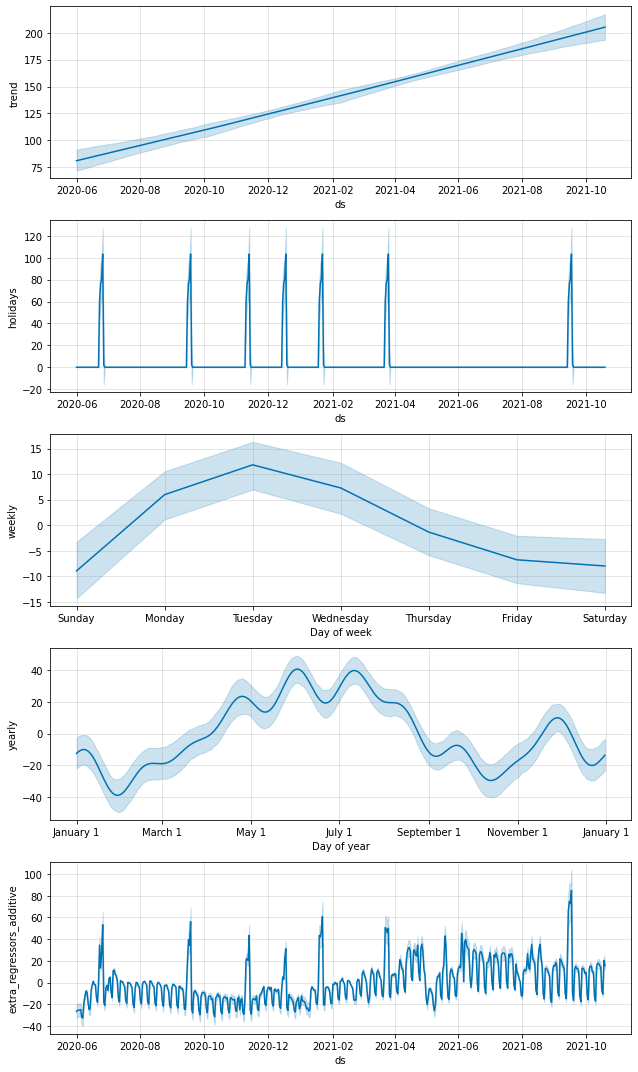

In [79]:
fig = m.plot_components(forecast)